![credit cards](https://unsplash.com/photos/na8l3EPqpvY/download?force=true&w=640)
# Let's Cluster some Credit Cards!
In this notebook I'll try to cluster some credit cards. we go through preprocessing, choose a model and train it on our data, and then evaluate and interpret our outcomes. 

# Libraries
Let's begin by importing libraries. I have added comments that shows the use case of each library.

In [1]:
# Essentials:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# t-SNE visualization
from sklearn.manifold import TSNE

# imputation
from sklearn.impute import KNNImputer

# Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# K-means for Clustering
from sklearn.cluster import KMeans

# elbow method
from yellowbrick.cluster import KElbowVisualizer

# cluster metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Take a look at Dataset
Let's take a look at our dataset. we're going to:
- load the dataset
- understand the features
- check for missing values ...
- ... and outliers
- determine whether it's possible to cluster these datapoints (using t-SNE)

## Load the dataset:

In [2]:
cc_general = pd.read_csv('../input/ccdata/CC GENERAL.csv')
cc_general.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Understand the features:

In [3]:
cc_general.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


CUSTID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases 

BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFFPURCHASES : Maximum purchase amount done in one-go

INSTALLMENTSPURCHASES : Amount of purchase done in installment

CASHADVANCE : Cash in advance given by the user

PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASESTRX : Numbe of purchase transactions made

CREDITLIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

## Check for missing values:

In [4]:
cc_general.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

## Check for outliers:

Using IQR, we can follow the below approach to find outliers:

- Calculate the first and third quartile (Q1 and Q3).
- Further, evaluate the interquartile range, IQR = Q3-Q1.
- Estimate the lower bound, the lower bound = Q1*1.5
- Estimate the upper bound, upper bound = Q3*1.5
- The data points that lie outside of the lower and the upper bound are outliers.

In [5]:
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

In [6]:
non_categorical_data = cc_general.drop(['CUST_ID'], axis=1)
for column in non_categorical_data.columns:
    data = non_categorical_data[column]
    percent = str(round(outlier_percent(data), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.68%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 8.98%
Outliers in "PURCHASES_TRX": 8.56%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 9.74%
Outliers in "PRC_FULL_PAYMENT": 16.47%
Outliers in "TENURE": 15.26%


# Preprocessing
in this part, I'm going to:
1. remove the outliers
2. impute missing data
3. scale the data
4. Reduce dimentions using PCA

## Removing the outliers
first, let's get rid of the noise. we're going to first set all outliers as `NaN`, so it will be taken care of in the next stage, where we impute the missing values. 

In [7]:
for column in non_categorical_data.columns:
    data = non_categorical_data[column]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) |(data > maximum))
    non_categorical_data[column].loc[outliers] = np.nan
    
non_categorical_data.isna().sum()

BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
CREDIT_LIMIT                         249
PAYMENTS                             808
MINIMUM_PAYMENTS                    1154
PRC_FULL_PAYMENT                    1474
TENURE                              1366
dtype: int64

## Imputing the missing data
I use `KNN imputer`: Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set.

In [8]:
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(non_categorical_data), columns=non_categorical_data.columns)
imp_data.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Scale the Data
I use `StandardScaler`

In [9]:
std_imp_data = pd.DataFrame(StandardScaler().fit_transform(imp_data), columns=imp_data.columns)
std_imp_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8950.0
mean,1.007140e-16,3.659946e-15,-2.328256e-15,6.933002e-15,6.562348e-16,8.309058e-16,-3.716084e-16,-6.162668e-17,2.353921e-16,7.161001e-16,-3.218468e-16,-3.808350e-15,3.697204e-15,-8.373687e-16,1.329911e-16,-2.147854e-15,0.0
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,0.0
min,-9.705408e-01,-4.155613e+00,-9.108903e-01,-6.680081e-01,-7.877087e-01,-6.489569e-01,-1.221758e+00,-7.445352e-01,-9.169952e-01,-7.471495e-01,-6.816338e-01,-9.664333e-01,-1.365289e+00,-1.191668e+00,-1.158670e+00,-4.495406e-01,0.0
25%,-8.698480e-01,3.667368e-01,-8.520893e-01,-6.680081e-01,-7.877087e-01,-6.489569e-01,-1.014125e+00,-7.445352e-01,-9.169952e-01,-7.471495e-01,-6.816338e-01,-8.736430e-01,-8.651825e-01,-8.090269e-01,-7.803818e-01,-4.495406e-01,0.0
50%,-2.885421e-01,3.667368e-01,-3.756604e-01,-5.869491e-01,-4.755205e-01,-6.489569e-01,2.404259e-02,-3.779201e-01,-4.976286e-01,-7.471495e-01,-6.816338e-01,-3.169012e-01,-4.134734e-01,-3.372865e-01,-4.243503e-01,-4.495406e-01,0.0
75%,5.627106e-01,3.667368e-01,6.123033e-01,3.670389e-01,5.317248e-01,5.417945e-01,1.062211e+00,4.286381e-01,9.701506e-01,4.370943e-01,4.785480e-01,6.110018e-01,6.496561e-01,6.767671e-01,6.364580e-01,-2.118122e-01,0.0
max,2.909752e+00,3.667368e-01,3.121026e+00,3.512621e+00,3.318057e+00,3.337981e+00,1.269843e+00,2.555014e+00,1.599199e+00,3.128553e+00,3.185639e+00,2.837969e+00,3.006609e+00,2.978734e+00,2.850989e+00,4.305042e+00,0.0


## Dimention Reduction using PCA
K-means, DBSCAN and agglomerative clustering, all use the Euclidean distance, which starts to lose its meaning when the number of dimensions starts increasing. so, before using these methods, we have to reduce the number of dimensions. I'm going to use PCA, which is by far the most popular dimensionality reduction algorithm. 

<div class="alert alert-warning" role="alert">
  ⚠ If you are not familiar with PCA or need to learn more about it, I highly recommend you read <a href="https://github.com/HalflingWizard/MachineLearning/blob/main/4-%20Dimensionality%20Reduction/PCA.md">my Notes</a> on this dimentionality reduction method, In which I cover almost anything you need to know about this algorithm.
</div>

here I set parameter `n_components` equals to 0.9, which means that the PCA will automatically produce enough PCs that will preserve 90% of variance in the dataset.

In [10]:
pca = PCA(n_components=0.9, random_state=42)
pca.fit(std_imp_data)
PC_names = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
pca_data = pd.DataFrame(pca.transform(std_imp_data), columns=PC_names)

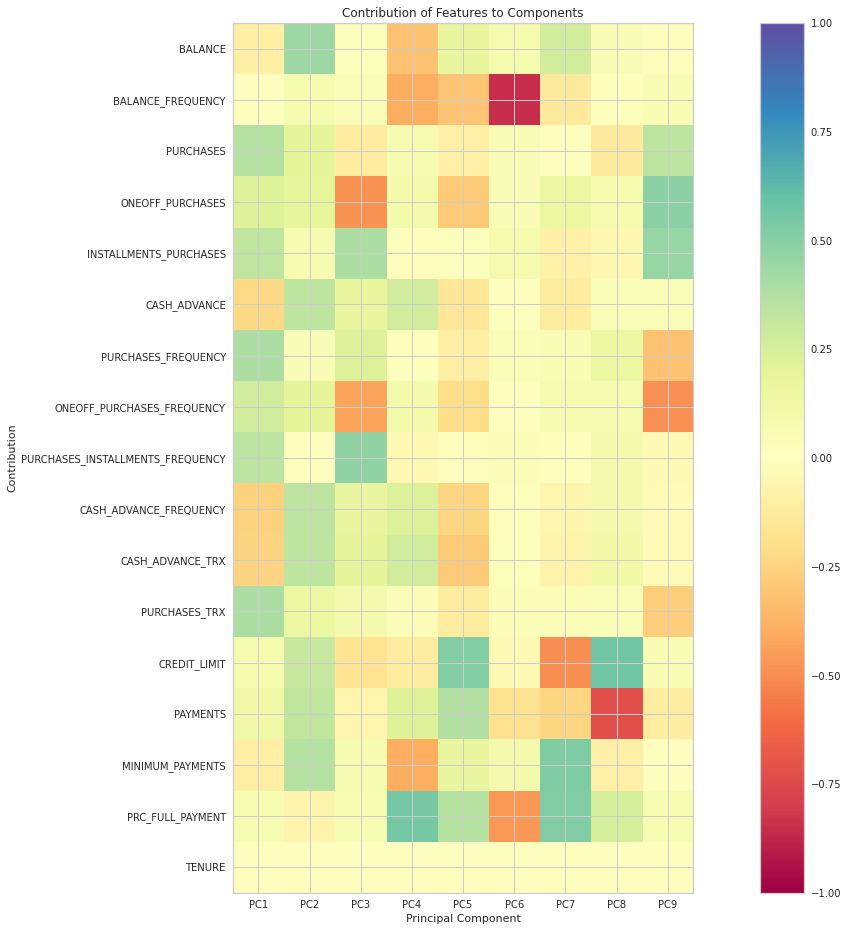

In [11]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.imshow(pca.components_.T,
           cmap="Spectral",
           vmin=-1,
           vmax=1,
          )
plt.yticks(range(len(std_imp_data.columns)), std_imp_data.columns)
plt.xticks(range(len(pca_data.columns)), pca_data.columns)
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title("Contribution of Features to Components")
plt.colorbar()

# Train the Model
now that we have done the preprocessing step, we can perform K-means clustering on our data. 

<div class="alert alert-warning" role="alert">
  ⚠ If you are not familiar with K-Means or need to learn more about it, I highly recommend you read <a href="https://github.com/HalflingWizard/MachineLearning/blob/main/3-%20Clustering/K-Means.md">my Notes</a> on this clustering method, In which I cover almost anything you need to know about this algorithm.
</div>

first, we have to find good parameters for our model.

## Find the `n_clusters` parameter using the elbow method

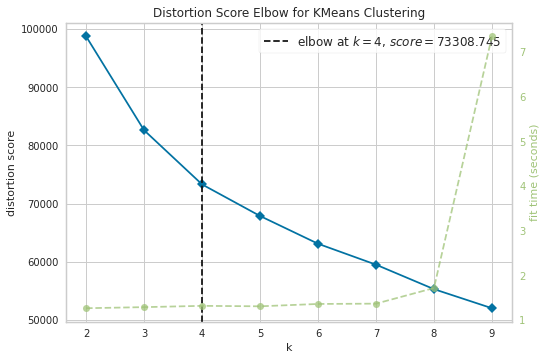

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))

distortion_visualizer.fit(pca_data)       
distortion_visualizer.show()       

so, as you can see, it seems the best value for `k` is 4.

In [13]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(pca_data)

Now I add these labels to 3 dataframes:
- `cc_general`: original dataframe
- `std_imp_data`: imputed, standard dataframe
- `pca_data`: Transformed data after PCA

In [14]:
cc_general['LABELS'] = labels
std_imp_data['LABELS'] = labels
pca_data['LABELS'] = labels

Let's see how our data is distributed among these 4 clusters:

<AxesSubplot:ylabel='LABELS'>

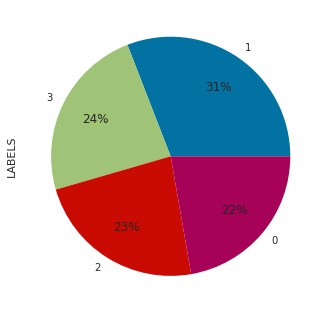

In [15]:
pca_data.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

# Evaluate the Model
Let's see how good/bad is our model.

we start by caculating two metrics: 
- **The Davis-Bouldin Index** is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.
- **The Silhouette Coefficient** is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters. 

In [16]:
print(f'Davies-Bouldin index = {davies_bouldin_score(pca_data, labels)}')
print(f'Silhouette Score = {silhouette_score(pca_data, labels)}')

Davies-Bouldin index = 1.392335574257734
Silhouette Score = 0.24574618350262167


now, let's get the Silhouette Plot:

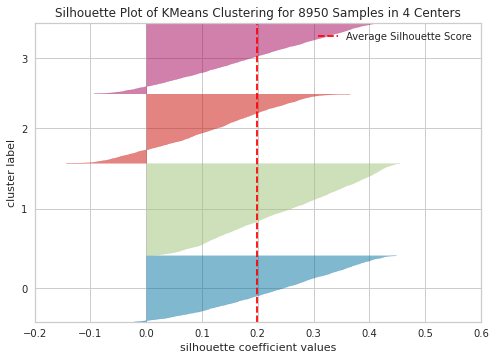

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 8950 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
visualizer = SilhouetteVisualizer(km_model, colors='yellowbrick')
visualizer.fit(pca_data.drop(['LABELS'],axis=1))
visualizer.show()

Here, the vertical dotted red line in this plot is the average score. It looks like our clustering method is good, since each cluster bumps out above the average, and the cluster scores look decent.

# Interpret the results
alright, we have nice clusters, but what do they mean? let's figure out.

## PCs vs Labels!
Let's see which PCs have higher values in each label.

In [18]:
def spider_plot(data, title):
    means = data.groupby("LABELS").mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    plt.figure(figsize=(10,10))
    plt.subplot(polar=True)
    for i in range(len(means)):
        plt.plot(label_loc, means[i], label=f'class {categories[i]}')
    plt.title(f'Feature comparison ({title})', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.legend()
    plt.show()

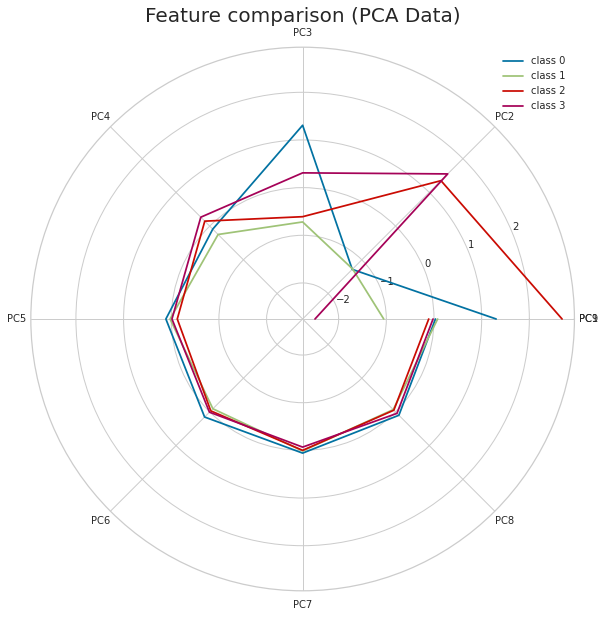

In [19]:
spider_plot(pca_data, 'PCA Data')

hmmm... It looks like PC1, PC2 and PC3 were the most important Principal Components. Let's get the same plot, this time for original features:

## Standard, Imputed Data vs Labels!
the following plot should give us a better understanding on our clusters:

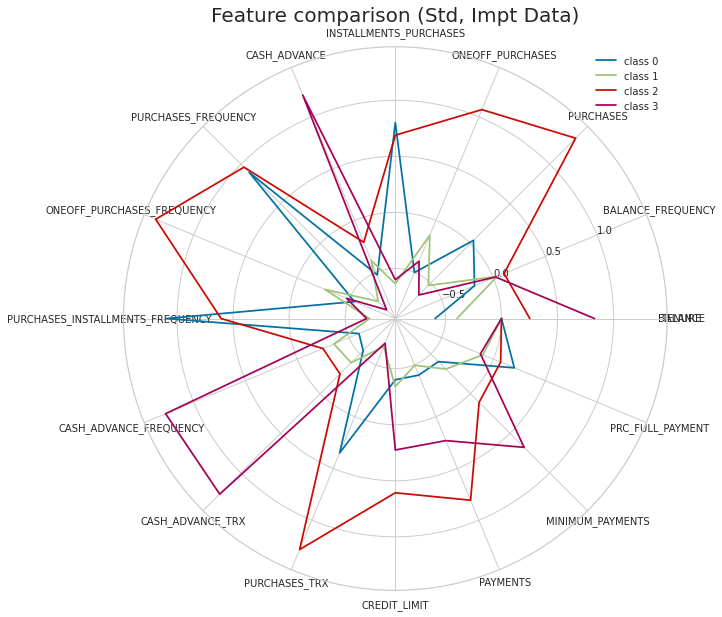

In [20]:
spider_plot(std_imp_data, 'Std, Impt Data')

Wow! now we are talking. I know it's hard to read, but I just want you to notice these points:
- Class 0 contains customers who don't make a lot of money (look at their `BALANCE`, it is the lowest of all) but this doen't keep them away from purchasing stuff! in terms of `PURCHASES`, they are the second class. how do they do this? take a closer look: they don't buy stuff in one go (they have lowest ammount of `ONEOFF_PURCHASES` and `ONEOFF PURCHASES FREQUENCY`) their key to success is _instalments!_ It's easy: if you don't make enough money to buy stuff in one go, just pay over a period of time. (They have highest values of `INSTALLMENTSPURCHASES` and `PURCHASESINSTALLMENTSFREQUENCY`  I refer to these people as **Dreamers** because although they don't make much money, lack of money doesn't prevent them from reaching for their dreams!
- Class 1 shows customers who are not very rich, and don't take risks. their `BALANCE` (amount left in their account to make purchases) is below average, and they don't purchase much. (their `PURCHASES` is below average as well, and their `PURCHASE FREQUENCY` is very low.) I call these people **Economicals**. to them, every penny is important.
- Class 2 contains customers who have a good income (second highest `BALANCE`) and are enjoying it! they purchase a lot (highest `PURCHASESFREQUENCY`), both in installments and in one-go. let's call them **Bourgeoisie**!
- Class 3 is mysterious. look at them! they have highest `BALANCE`, but lowest `PURCHASE` of all! it seems they only use their fortunes when they want pay in advance (highest `CASHADVANCE`, `CASHADVANCEFREQUENCY` and `CASHADVANCETRX`). A cash advance is a service provided by most credit card and charge card issuers. The service allows cardholders to withdraw cash, either through an ATM or over the counter at a bank or other financial agency, up to a certain limit. For a credit card, this will be the credit limit (or some percentage of it). so, these guys don't use their credit cards to buy stuff, instead, they get chash from ATMs to do so. why? it is beause they want to buy something illegal? Let's just call them **The Mafia** for now.

## Evaluating our hypothesis
now, I want to plot our data using only `BALANCE` and `PURCHASES`. this is my hypothesis:
- If `BALANCE` is low and `PURCHASES` is high ➡ Class 0 (Dreamers ✨)
- If `BALANCE` is low and `PURCHASES` is low ➡ Class 1 (Economicals 💲)
- If `BALANCE` is high and `PURCHASES` is high ➡ Class 2 (Bourgeoisie 🛍️)
- If `BALANCE` is high and `PURCHASES` is low ➡ Class 3 (The Mafia 🕶️)

In [21]:
def colorful_scatter(data):   
    LABEL_COLOR_MAP = {0 : 'y',
                       1 : 'g',
                       2 : 'm',
                       3 : 'k'
                       }
    sns.jointplot(data=data, x="BALANCE", y="PURCHASES", hue="LABELS", palette=LABEL_COLOR_MAP, alpha=0.6, height=10)

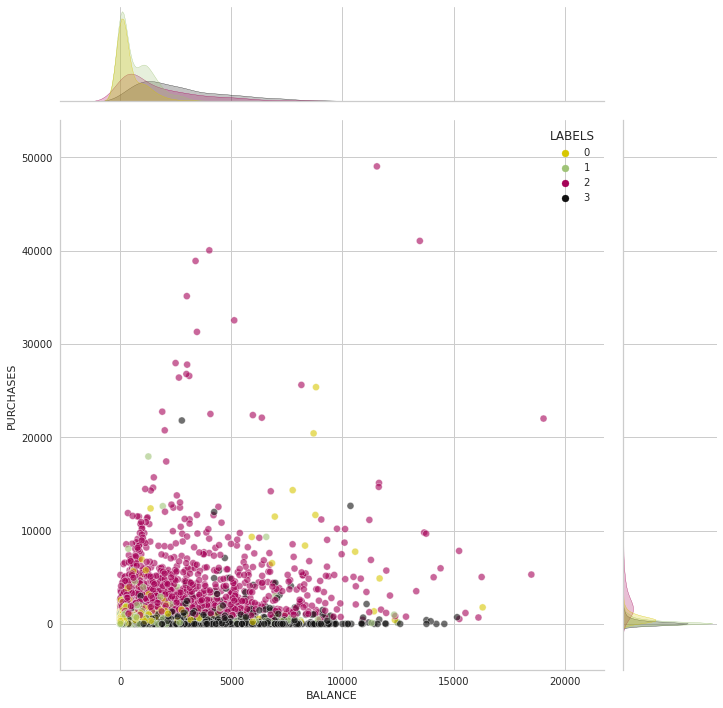

In [22]:
colorful_scatter(cc_general)

It's hard to read... let's use our normalized dataframe:

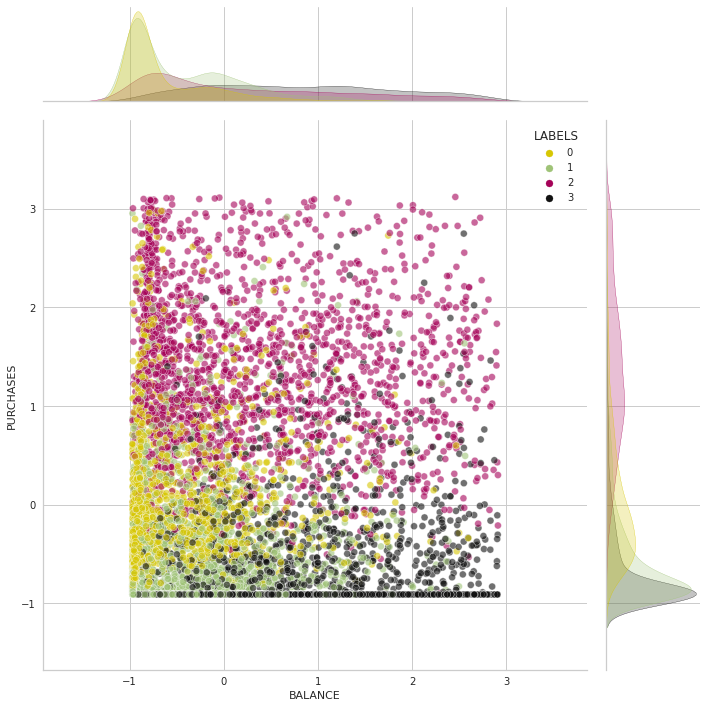

In [23]:
colorful_scatter(std_imp_data)

The following KDE plot also helps proving my point:

<AxesSubplot:xlabel='BALANCE', ylabel='PURCHASES'>

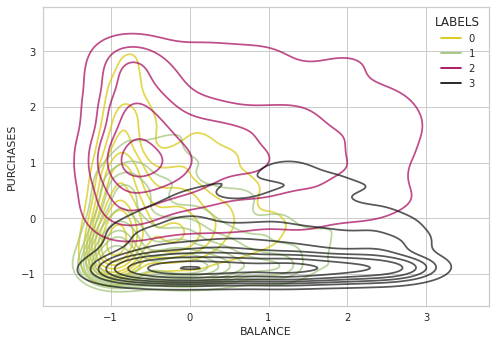

In [24]:
sns.kdeplot(data=std_imp_data, x="BALANCE", y="PURCHASES", hue="LABELS", palette={0 : 'y', 1 : 'g', 2 : 'm', 3 : 'k'}, alpha=.7, height=20)

It looks like my hypothesis was quite right. 
in this plot, it is clear that:
- people of Class 0 spend a lot while they have low balance.
- people of Class 1 have a low balance and spend less than others
- people of Class 2 have high balance and purchase a lot
- people of Class 3 don't purchase much, although they have lots of money

we can further investigate this hypothesis using kde plots:

In [25]:
def kde_plot(data,x):
    LABEL_COLOR_MAP = {0 : 'y',
                   1 : 'g',
                   2 : 'm',
                   3 : 'k'
                   }
    sns.kdeplot(data=data, x=x, hue="LABELS", palette=LABEL_COLOR_MAP)

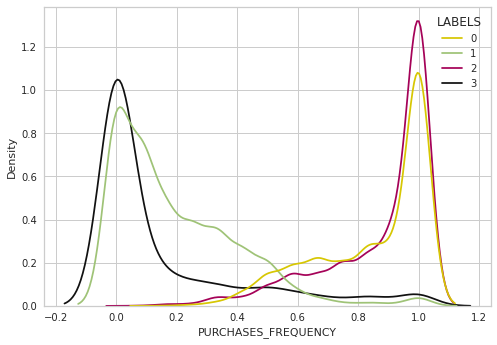

In [26]:
kde_plot(cc_general, 'PURCHASES_FREQUENCY')

looking at this plot, it is obvious that ***the mafia*** and ***economicals*** are purchasing less often than ***dreamers*** and ***Bourgeoisie***

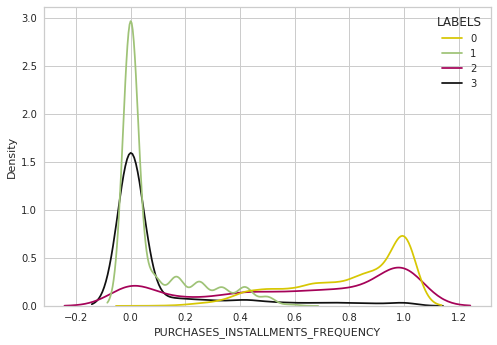

In [27]:
kde_plot(cc_general, 'PURCHASES_INSTALLMENTS_FREQUENCY')

This plot shows how ***the dreamers*** are trying to buy whatever they persue, by buying first and paying later.

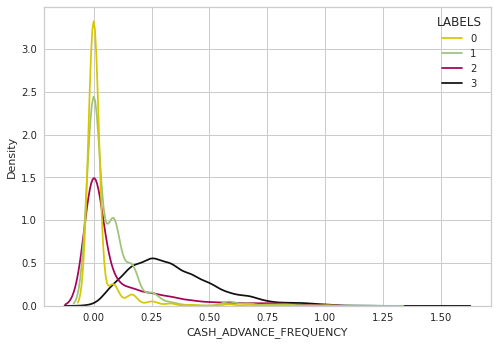

In [28]:
kde_plot(cc_general, 'CASH_ADVANCE_FREQUENCY')

and this plot shows that the infamous ***mafia*** are getting cash from ATMs more often than other groups. should we call the cops? 😈

# Conclusion
Congrats! we found data hidden in this dataset by using cool ML tools. 🥳

Let's keep learning!

<div class="alert alert-danger" role="alert" style="text-align:center;">
    I hope you enjoyed this tutorial. If you did, please consider subscribing to <b><a href="https://www.youtube.com/channel/UC34Gj0-vHuBiTNEYlP7wczg">my YouTube Channel ▶</a></b>
</div>

<center><h2><span style="font-family:cursive;"> Also, please Upvode! 😜 </span></h2></center>